In [94]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [95]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

In [96]:
class_names = train_data.classes
len(train_data), len(test_data), class_names

(60000,
 10000,
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

In [97]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

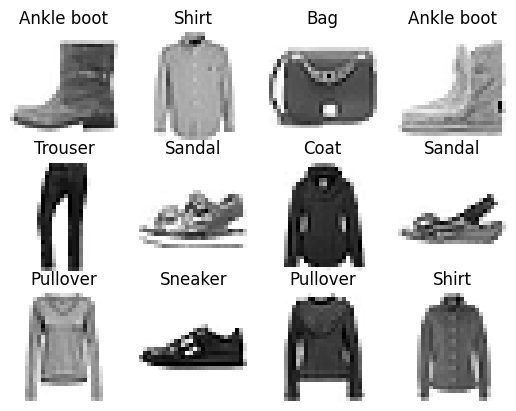

In [98]:
# plt.imshow(image[0, 5:6, :])
torch.manual_seed(42)

rows, cols = 3, 4
for i in range(cols*rows):
    random_idx = torch.randint(0, len(train_data), size=[1])
    image, label = train_data[random_idx.item()]
    plt.subplot(rows, cols, i+1)
    plt.imshow(image.permute(1, 2, 0), cmap='binary')
    plt.title(class_names[label])
    plt.axis(False)

In [99]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [100]:
len(train_loader)

1875

In [101]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

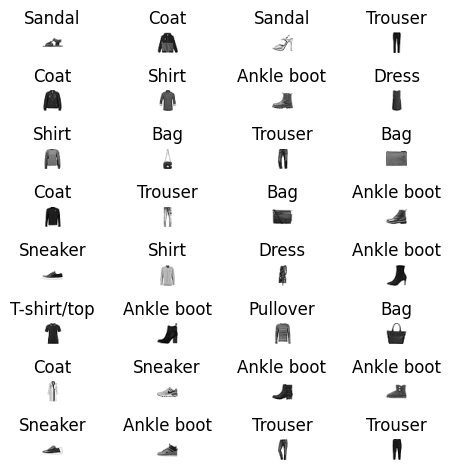

In [102]:
for i in range(len(train_features_batch)):
    train_feature = train_features_batch[i]
    train_label = train_labels_batch[i]
    plt.subplot(8, 4, i+1)
    plt.imshow(train_feature.permute(1,2,0), cmap='binary')
    plt.title(class_names[train_label.item()])
    plt.axis(False)
    plt.tight_layout()
    

In [103]:
class FashionMNISTModel0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape) -> None:
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [104]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = 'cpu'
device


'cpu'

In [105]:
torch.manual_seed(42)

model_0 = FashionMNISTModel0(
    input_shape=28*28,
    hidden_units=50,
    output_shape=len(class_names),
).to(device)

In [106]:
# torch.manual_seed(42)

# # Setup model with input parameters
# model_0 = FashionMNISTModel0(
#     input_shape=28*28, # this is 28*28
#     hidden_units=10, # how mnay units in the hidden layer
#     output_shape=len(class_names) # one for every class
# ).to("cpu")

# model_0

In [107]:
dummy_x = torch.rand([1,1,28,28])

with torch.inference_mode():
    dummy_pred = model_0(dummy_x.to(device))

torch.softmax(dummy_pred, dim=1).sum()

tensor(1.0000)

In [108]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [109]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
import time

# Set the seed and start the timer
torch.manual_seed(42)
# train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3
test_loss = 0

start_time = time.time()

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_loader):
        model_0.train() 
        # 1. Forward pass
        train_pred = model_0(X.to(device))

        # 2. Calculate loss (per batch)
        loss = loss_fn(train_pred, y.to(device))

        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples. Loss: {loss:.3f}")

    # Divide total train loss by length of train train_loader (average loss per batch per epoch)
    print(f'train_loss: {train_loss:.3f} ')
    print(f'len(train_loaderl): {len(train_loader)} ')
    train_loss /= len(train_loader)
    
    ### Testing
    # # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            # 1. Forward pass
            test_pred = model_0(X.to(device))
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y.to(device)) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_score(y.cpu(), test_pred.argmax(dim=1).cpu())
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_loader)

    # Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%\n")

print(f'Delay: {time.time() - start_time} s')
print(f'Device: {device}')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples. Loss: 2.313


Looked at 12800/60000 samples. Loss: 0.770
Looked at 25600/60000 samples. Loss: 0.656
Looked at 38400/60000 samples. Loss: 0.456
Looked at 51200/60000 samples. Loss: 0.386
train_loss: 1491.273 
len(train_loaderl): 1875 


 33%|███▎      | 1/3 [00:13<00:26, 13.11s/it]


Train loss: 0.79535 | Test loss: 0.48969, Test acc: 82.10%

Epoch: 1
-------
Looked at 0/60000 samples. Loss: 0.431
Looked at 12800/60000 samples. Loss: 0.518
Looked at 25600/60000 samples. Loss: 0.362
Looked at 38400/60000 samples. Loss: 0.385
Looked at 51200/60000 samples. Loss: 0.233
train_loss: 835.002 
len(train_loaderl): 1875 


 67%|██████▋   | 2/3 [00:26<00:13, 13.03s/it]


Train loss: 0.44533 | Test loss: 0.47169, Test acc: 82.42%

Epoch: 2
-------
Looked at 0/60000 samples. Loss: 0.419
Looked at 12800/60000 samples. Loss: 0.683
Looked at 25600/60000 samples. Loss: 0.259
Looked at 38400/60000 samples. Loss: 0.318
Looked at 51200/60000 samples. Loss: 0.365
train_loss: 742.805 
len(train_loaderl): 1875 


100%|██████████| 3/3 [00:39<00:00, 13.02s/it]


Train loss: 0.39616 | Test loss: 0.41697, Test acc: 84.74%

Delay: 39.054901361465454 s
Device: cpu


## 15 hidden layers
CPU: 34.34933876991272 s\
GPU: 53.58372449874878 s
## 150 hidden layes
CPU: 52.85621690750122 s\
GPU: 54.12273192405701 s
## 50 ** 3 hidden layers
CPU: 39.054901361465454 s\
GPU: 79.52518057823181 s
